In [1]:
%pylab inline
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import findspark
findspark.init()

In [3]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',4)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','40G') 
conf.set('spark.executor.memory','20G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [5]:
sc=spark.sparkContext

In [10]:
N=60

In [504]:

df=pd.read_csv("../input/train_1_wo_page.csv",nrows=100000000,index_col=0)

In [721]:
def smape(estimator, X,y_true):
    y_pred=estimator.predict(X)
    #print y_true.shape,y_pred.shape
    r=np.abs(y_true-y_pred)/(np.abs(y_true)+np.abs(y_pred)+1e-10)
    r[(y_true==0) & (y_pred==0)]=0
    return -np.mean(r)
def med_norm(X,y):
    assert y is None or X.shape[0]==y.shape[0]
            
    med=np.median(X,axis=1)
    med[med==0]=1
    X=X/med.reshape(-1,1)
    if 1:
        xx=np.array([np.array([np.median(x[-j:]) for j in [3,7,14,28,45,60]]) for x in X])
        oldX=X-xx[:,-1].reshape(-1,1)
        #X=(np.concatenate([xx,oldX],axis=1))
        X=xx

    if y is not None: y=y/med
    return (X.astype(np.float32),y,med)

def make_X(s,D):
    n=len(s)
    X=[];y=[]
    for i in range(n):
        if i+N+D-1<n:
            x=s[i:i+N]
            if np.mean(x)>0.1:
                X.append(x)
                y.append(s[i+N+D-1])
    X,y=(np.array(X),np.array(y))
    return med_norm(X,y)

def make_testX(s):
    X=s[-N:].reshape(1,-1)
    return med_norm(X,None)

def expand_alpha_up(alpha):
    lst=[alpha]
    while(alpha<1e4 and len(lst)<5):
        alpha=alpha*3.0
        lst.append(alpha)
    return lst
def expand_alpha_down(alpha):
    lst=[alpha]
    while(alpha>1e-4 and len(lst)<5):
        alpha=alpha/3.0
        lst.append(alpha)
    return lst

In [746]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
class RidgeK(object):
    def __init__(self,alpha=1.0,k=2.0):
        assert(k>1 or np.isinf(k))
        self.k=float(k)
        self.model=Ridge(alpha=alpha)
        
    def fit(self,X,y):
        k=self.k
        X=X.copy()
        y=y.copy()
        if not np.isinf(k):
            X[X>k]=k
            X[X<1/k]=1/k
            y[y>k]=k
            y[y<1/k]=1/k
        self.model.fit(X,y)
        return self
    def predict(self,X):
        return self.model.predict(X)
    
    def score(self,X,y):
        return self.model.score(X,y)
    
    def get_params(self,deep=True):
        return {'alpha':self.model.alpha, 'k':self.k}
    
    def set_params(self, **params):
        if 'alpha' in params:
            alpha=params['alpha']
            self.model.set_params(alpha=alpha)
        if 'k' in params:
            k=params['k']
            assert(k>1 or np.isinf(k))
            self.k=float(k)
        return self
    
class RidgeCV(object):
    def __init__(self,X,y):
        idx=np.random.permutation(range(len(y)))
        self.X=X[idx,]
        self.y=y[idx]        
        self.alpha=np.array([10.0,3.0,1.0])
        self.K=np.array([1.05,1.1,1.25,1.75, 3])
        self.dir=None
        self.n_fit=0
    def fit(self):
        X,y=self.X,self.y
        self.n_fit+=1
        clf = RidgeK()
        param_grid=[{"alpha":self.alpha, 'k':self.K}]
        gscv = GridSearchCV(clf, param_grid,error_score=2.0,scoring=smape,n_jobs=1)
        gscv.fit(X,y)
        best_alpha=gscv.best_params_['alpha']
        #print self.alpha,self.K
        if self.n_fit<100 and self.dir!='up' and len(self.alpha)>1 and best_alpha==np.min(self.alpha):
            self.alpha=expand_alpha_down(best_alpha)
            self.dir='down'
            return self.fit()
        elif self.n_fit<100 and self.dir!='down' and len(self.alpha)>1 and best_alpha==np.max(self.alpha):
            self.alpha=expand_alpha_up(best_alpha)
            self.dir='up'
            return self.fit()
        else:
            #print "best_model found:", gscv.best_params_,  gscv.best_score_
            #print zip(gscv.cv_results_['mean_test_score'],gscv.cv_results_['mean_train_score'])
            self.model=gscv
        return self
    def score(self,X,y):
        return self.model.score(X,y) 
    def predict(self,X):
        return self.model.predict(X)
        

In [739]:
def train_pred(s):
    testX,_,m=make_testX(s)  
    predy=[]
    for D in range(1,61):
        X,y,_=make_X(s,D)
        clf = RidgeCV(X,y)
        clf.fit()
        thispred= clf.predict(testX)*m
        predy.append(thispred[0])
    return np.array(predy,dtype=np.float32)

In [740]:
def train_pred2(s):
    testX,_,m=make_testX(s)  
    testX=np.concatenate([np.repeat(testX,60,axis=0),np.eye(60)],axis=1)
    
    XX=[]
    yy=[]
    for D in range(1,61):
        X,y,_=make_X(s,D)
        yy.append(y)
        flag=np.zeros(shape=[1,60])
        flag[:,D-1]=1
        XX.append(np.concatenate([X,np.repeat(flag,X.shape[0],axis=0)],axis=1))
    XX=np.concatenate(XX)
    yy=np.concatenate(yy)
    clf = RidgeCV(XX, yy)    
    clf.fit()
    thispred= clf.predict(testX)*m
    return thispred

In [768]:
s=df.iloc[int(np.random.random()*df.shape[0])].values

In [769]:
%time p=train_pred2(s)

CPU times: user 35.6 s, sys: 1.03 s, total: 36.7 s
Wall time: 11 s


(-523.5, 1570.5)

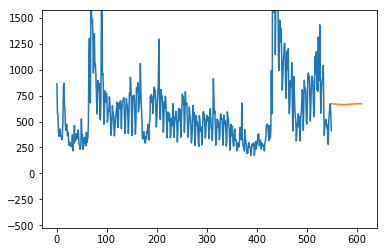

In [770]:
u=len(s)+len(p)
a=np.zeros(u)+np.nan
a[:len(s)]=s
b=np.zeros(u)+np.nan
b[-len(p):]=p
v=np.median(s)
plt.plot(a),plt.plot(b)
plt.ylim([-v,3*v])

In [771]:
%time p=train_pred(s)

CPU times: user 29 s, sys: 53.7 ms, total: 29.1 s
Wall time: 29 s


(-523.5, 1570.5)

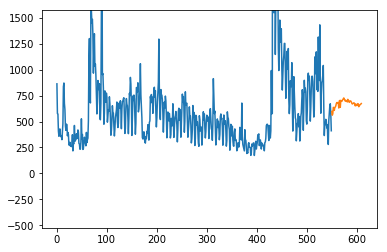

In [772]:
u=len(s)+len(p)
a=np.zeros(u)+np.nan
a[:len(s)]=s
b=np.zeros(u)+np.nan
b[-len(p):]=p
v=np.median(s)
plt.plot(a),plt.plot(b)
plt.ylim([-v,3*v])

In [654]:
a=np.zeros([5,5])

In [657]:
a[[1,2],]

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [70]:
dfRDD.count()

145063

In [101]:
predRDD=dfRDD.map(lambda u: train_predict(u)).cache()

In [94]:
predRDD.count()

145063

In [154]:
predictions = pd.DataFrame(predRDD.collect())

In [157]:
predictions=predictions.loc[:,sorted(predictions.columns)]

In [158]:
predictions=predictions.sort_index()

In [159]:
predictions.head()

431        432        433        434        435        436  \
0  17.792795  17.828097  17.216361  17.295291  16.884515  16.971772   
1  19.018964  18.765671  19.070600  18.659380  18.632302  18.039346   
2   3.627019   3.627019   3.496471   3.715337   3.496471   3.496471   
3  13.671696  13.492466  13.708429  13.671696  13.381540  13.381540   
4  10.201021  10.201021  11.217070  12.368774  11.068911  10.943078   

         437        438        439        440    ...            481  \
0  16.884515  17.228334  16.674700  17.228334    ...      17.688245   
1  17.958111  17.720907  17.729157  17.694467    ...      17.453109   
2   3.474788   3.670929   3.670929   3.670929    ...       3.490217   
3  13.344807  13.242105  13.560771  13.560771    ...      13.693476   
4  10.998329  11.004847  11.004847  10.428995    ...       9.776419   

         482        483        484        485        486        487  \
0  18.203459  18.203459  18.203459  17.723579  17.497110  17.767175   
1  18.076478  17.812628  18.287037  18.367839  19.006431  19.607461   
2   3.337987   3.315261   3.468534   3.468534   3.490217   3.603027   
3  13.616336  13.594046  14.271563  14.294382  13.617352  13.683320   
4  10.928123  12.079827  12.361467  12.162137  12.299699  13.864087   

         488        489        490  
0  17.202570  17.085188  17.167268  
1  19.612611  19.543033  18.964355  
2   3.450796   3.581344   3.801975  
3  13.707670  13.528440  13.208026  
4  14.283289  14.558412  14.476102  

[5 rows x 60 columns]

In [166]:
import sys  
reload(sys)  
sys.setdefaultencoding('utf8')

In [167]:
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [168]:
predictions.index=idx

In [169]:
predictions.columns=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
predictions.index.name="Page"

In [213]:
predictions.head(100).tail(20)

2017-01-01  2017-01-02  \
Page                                                                         
Juksy_zh.wikipedia.org_all-access_spider              2.642763    2.537542   
K.A.R.D_zh.wikipedia.org_all-access_spider            0.000000    0.000000   
KNK_zh.wikipedia.org_all-access_spider                8.542786    8.542786   
KUROMUKURO_zh.wikipedia.org_all-access_spider         3.775146    3.942103   
Kara_zh.wikipedia.org_all-access_spider              12.917522   12.867274   
Kill_Me_Heal_Me_zh.wikipedia.org_all-access_spider   15.144240   15.848191   
Lady_Gaga_zh.wikipedia.org_all-access_spider         17.513349   17.472312   
Legal_high_zh.wikipedia.org_all-access_spider        14.824532   15.803534   
LoveLive!_zh.wikipedia.org_all-access_spider         27.566999   27.161286   
LoveLive!_Sunshine!!_zh.wikipedia.org_all-acces...   12.011083   11.669961   
Lovelyz_zh.wikipedia.org_all-access_spider           28.482116   28.226266   
Lulu_zh.wikipedia.org_all-access_spider               4.001043    4.001043   
MADTOWN_zh.wikipedia.org_all-access_spider            9.059997    8.630299   
MAMAMOO_zh.wikipedia.org_all-access_spider           10.557745   10.512608   
MONSTA_X_zh.wikipedia.org_all-access_spider          19.462365   18.649198   
Madame_Antoine_zh.wikipedia.org_all-access_spider     6.279981    6.279981   
Mamamoo_zh.wikipedia.org_all-access_spider           25.007784   25.705813   
Mike_D._Angelo_zh.wikipedia.org_all-access_spider     8.783927    8.840944   
Miss_A_zh.wikipedia.org_all-access_spider            14.290872   14.238553   
Missing9_zh.wikipedia.org_all-access_spider          14.245026   15.673498   

                                                    2017-01-03  2017-01-04  \
Page                                                                         
Juksy_zh.wikipedia.org_all-access_spider              2.459177    2.254548   
K.A.R.D_zh.wikipedia.org_all-access_spider            0.000000    0.000000   
KNK_zh.wikipedia.org_all-access_spider                8.542786    8.345818   
KUROMUKURO_zh.wikipedia.org_all-access_spider         4.268708    3.942103   
Kara_zh.wikipedia.org_all-access_spider              12.812162   12.702841   
Kill_Me_Heal_Me_zh.wikipedia.org_all-access_spider   16.496693   16.490422   
Lady_Gaga_zh.wikipedia.org_all-access_spider         17.493335   17.431274   
Legal_high_zh.wikipedia.org_all-access_spider        16.518709   16.813416   
LoveLive!_zh.wikipedia.org_all-access_spider         27.187402   27.119026   
LoveLive!_Sunshine!!_zh.wikipedia.org_all-acces...   12.608450   11.886362   
Lovelyz_zh.wikipedia.org_all-access_spider           27.970721   27.713914   
Lulu_zh.wikipedia.org_all-access_spider               4.576609    4.576609   
MADTOWN_zh.wikipedia.org_all-access_spider            8.266102    8.266102   
MAMAMOO_zh.wikipedia.org_all-access_spider           10.512608   10.422334   
MONSTA_X_zh.wikipedia.org_all-access_spider          18.562055   18.384241   
Madame_Antoine_zh.wikipedia.org_all-access_spider     6.279981    6.095327   
Mamamoo_zh.wikipedia.org_all-access_spider           25.058658   25.278795   
Mike_D._Angelo_zh.wikipedia.org_all-access_spider     8.840944    8.428844   
Miss_A_zh.wikipedia.org_all-access_spider            14.537945   14.060559   
Missing9_zh.wikipedia.org_all-access_spider          15.681342   17.179979   

                                                    2017-01-05  2017-01-06  \
Page                                                                         
Juksy_zh.wikipedia.org_all-access_spider              2.170371    2.170371   
K.A.R.D_zh.wikipedia.org_all-access_spider            0.000000    0.000000   
KNK_zh.wikipedia.org_all-access_spider                8.302749    8.521997   
KUROMUKURO_zh.wikipedia.org_all-access_spider         3.949411    3.949411   
Kara_zh.wikipedia.org_all-access_spider              12.767626   12.703743   
Kill_Me_Heal_Me_zh.wikipedia.org_all-access_spider   17.145195   17.7048

In [171]:
submission=predictions.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [173]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  17.792795
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.018964
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   3.627019
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.671696
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.201021

In [174]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [191]:
keys.index=keys.index.astype(np.unicode)

In [182]:
submission.name.map(lambda u: type(u)).value_counts()

<type 'unicode'>    8703780
Name: name, dtype: int64

In [193]:
pd.Series(keys.index.map(lambda u: type(u))).value_counts()

<type 'unicode'>    8703780
dtype: int64

In [194]:
keys_dict=keys["Id"].to_dict()

In [195]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [196]:
submission.isnull().sum().sum()

0

In [208]:
np.mean(submission.Visits<0.01)

0.027811134932178891

In [209]:
submission.loc[submission.Visits<0.01,"Visits"]=0

In [210]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  17.792795  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.018964  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   3.627019  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.671696  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.201021  75bae1fb2637

In [212]:
submission[["Id","Visits"]].to_csv("../submission/sub_regmax60.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")

In [43]:
spark.stop()